In [153]:
import sympy as sp
from sympy import Matrix as spmtx
from sympy import *
from sympy import symbols as syms
from sympy.utilities.lambdify import lambdify, lambdastr
import math
from collections import deque
import copy
from copy import deepcopy
import random
import numpy as np
import time
from scipy import integrate as sci_int
import matplotlib.pyplot as plt

In [154]:
avaliable_classes = ['mono_poly']

In [155]:
def condition_num(A, norm = None):
    min_dim = min(A.shape)
    if A.rank() != min_dim:
        return -1 # since condition number is geq 1, this indicate it is not full rank
    else:
        npA = np.array(A).astype(np.float64)
        cond = np.linalg.norm(np.linalg.pinv(npA)) * np.linalg.norm(npA)
        # cond = A.pinv().norm() * A.norm()
        return cond

In [156]:
def get_class_name(obj):
    return obj.__class__.__name__

In [157]:
class mono_poly:
    '''
    The monomial polynomial basis class
    data_field:
        var_list: A list of symbols for different variables
        num_var: The number of variables
        degree: The total degree of the polynomial
        base: A list of terms that the basis consists
        base_vec: A sympy matrix (vector) of each element in the basis.
        coeff: A list of coeffs related to each basis
    '''
    
    
    def _gen_terms(self, var_list, total_degree, term):
        '''
        Description:
            Generate all the terms in a basis of the polynomial space consisted of monomial polynomials.
        Reference:
            None
        Input:
            var_list --- a deque of symbols in the monomials
            total_degree --- the maximun degree of the polynomial
            term --- A list of terms in the basis, start with [1] when being called
        '''
        terms = []
        if len(var_list) == 1:
            term *= var_list[0] ** total_degree
            terms.append(term)
            return terms
        elif total_degree == 0:
            term *= 1
            terms.append(term)
            return terms
        else:
            for i in range(total_degree, -1, -1):
                var_list_further = copy.deepcopy(var_list)
                var = var_list_further.popleft()
                term_further = term * var ** i
                terms += self._gen_terms(var_list_further, total_degree - i, term_further)
            return terms
    

    def __init__(self, deg, num_var, coeff=None):
        '''
        Description:
            Initalize a basis of the polynomail space by the first kind chebyshev polynomials.
        Input:
            deg --- The max degree of the polynomail space
            num_var --- number of variables in the polynomial space
        '''
        self.degree = deg
        self.num_var = num_var
        var_list = deque()
        for i in range(num_var):
            var_list.append(syms('x_' + str(i)))
        self.var_list = var_list
        terms = []
        for i in range(deg, -1, -1):
            terms += self._gen_terms(self.var_list, i, 1)
        self.base = terms
        self.base_vec = spmtx(terms)
        if coeff == None:
            pass

        self.coeff = coeff
    
    
    def c_extract_map(self, poly, basis, num_var=0):
        '''
        Description:
            Extract the coefficients of an element in a monomial basis from the input polynomial
        Input:
            deg --- The max degree of the polynomail space
            num_var --- number of variables in the polynomial space
            num_var --- not really needed
        '''
        p = sp.expands(poly)
        c = p.coeff(basis)
        if len(c.free_symbols) == 0:
            return c
        else:
            return sp.core.numbers.Zero()

In [187]:
class cheby_second_kind:
    '''
    The chebyshev first kind polynomial basis class
    data_field:
        var_list: A list of symbols for different variables
        num_var: The number of variables
        degree: The total degree of the polynomial
        base: A list of terms that the basis consists
        base_vec: A sympy matrix (vector) of each element in the basis.
        coeff: A list of coeffs related to each basis
    '''
    def _gen_terms_biv(self, total_degree):
        '''
        Description:
            Generate all the terms in a bases of bivaraite polynomials using
            bivariate chebyshev polynomial of the first kind
        Reference:
             The construction of multivariate chebyshev is based on what Gergely Mádi-Nagy proposed in his
            "Polynomial bases on the numerical solution of the multivariate discrete moment problem"
        Input:
            total_degree --- the maximun degree of the polynomial
        '''
        var_list = []
        for i in range(len(self.var_list)):
            var_list.append(self.var_list.popleft())
        self.var_list = deque()
        self.var_list.append(var_list[0])
        terms_x_0 = self._gen_terms_uni(total_degree)
        self.var_list.popleft()
        
        self.var_list.append(var_list[1])
        terms_x_1 = self._gen_terms_uni(total_degree)
        self.var_list.popleft()
        
        for var in var_list:
            self.var_list.append(var)
        terms = []
        for order_1 in range(len(terms_x_1)):
            for order_0 in range(len(terms_x_0) - order_1):
                terms.append(terms_x_0[order_0] * terms_x_1[order_1])
                # terms.append(sp.expand(x_0 * x_1))
        return terms
    
    
    def _gen_terms_uni(self, total_degree):
        '''
        Description:
            Generate all the terms in a bases of univaraite polynomials using
            univariate chebyshev polynomial of the second kind
        Reference:
            https://en.wikipedia.org/wiki/Chebyshev_polynomials
        Input:
            total_degree --- the maximun degree of the polynomial
        '''
        if total_degree == 0:
            return [1]
        U = [1, 2 * self.var_list[0]]
        for i in range(2, total_degree + 1):
            n_term = 2 * self.var_list[0] * U[i-1] - U[i-2]
            n_term = sp.simplify(n_term)
            n_term = sp.expand(n_term)
            U.append(n_term)
        return U
    

    def __init__(self, deg, num_var, coeff=None):
        '''
        Description:
            Initalize a basis of the polynomial space by the second kind chebyshev polynomials.
        Input:
            deg --- The max degree of the polynomail space
            num_var --- number of variables in the polynomial space
        '''
        if num_var > 2:
            raise ValueError("Only support 2 variable max")
        
        self.degree = deg
        self.num_var = num_var
        
        self.var_list = deque()
        for i in range(num_var):
            self.var_list.append(syms('x_' + str(i)))
        
        if num_var == 1:
            terms = self._gen_terms_uni(self.degree)
        elif num_var == 2:
            terms = self._gen_terms_biv(self.degree)

        self.base = terms
        self.base_vec = spmtx(terms) # arrange the terms in a vector format
        if coeff == None:
            pass
        self.coeff = coeff
    
    
    def c_extract_map(self, poly, basis, num_var):
        '''
        Description:
            Using orthogonality to extract the coefficient of a vector in the basis in the input polynomial.
            The basis should be generated by the constructor of this class.
        Reference:
            "Polynomial bases on the numerical solution of the multivariate discrete moment problem"
        Input:
            poly --- A given polynomial
            basis --- An element in the first kind chebyshve basis 
            num_var --- Univariate vs Bivariate
        '''
        if num_var > 2:
            raise ValueError("Only support 2 variable max")
        # Univariate
        if num_var == 1:
            weight = sqrt(1 - self.var_list[0] ** 2)
            f = lambdify(self.var_list[0], (poly * basis) * sqrt((1 - self.var_list[0] ** 2)))
            r = sci_int.quad(f, -1, 1)[0]
            if r < 1e-10:
                return 0
            else:
                f = lambdify(self.var_list[0], (basis * basis) * sqrt((1 - self.var_list[0] ** 2)))
                norm = sci_int.quad(f, -1, 1)[0]
                return round(r / norm, 10)
        # Bivariate
        if num_var == 2:
            weight = sqrt(1 - self.var_list[0] ** 2) * sqrt(1 - self.var_list[1] ** 2)
            f = lambdify(self.var_list, poly * basis * weight)
            r = sci_int.nquad(f, [[-1,1],[-1, 1]])[0]
            if r < 1e-10:
                return 0
            else:
                f = lambdify(self.var_list, (basis * basis) * weight)
                norm = sci_int.nquad(f, [[-1,1],[-1, 1]])[0]
                return round(r / norm, 10)

In [186]:
u = cheby_first_kind(deg=2, num_var=2)
u.base

[1,
 x_0,
 2*x_0**2 - 1,
 x_1,
 x_0*x_1,
 x_1*(2*x_0**2 - 1),
 2*x_1**2 - 1,
 x_0*(2*x_1**2 - 1),
 (2*x_0**2 - 1)*(2*x_1**2 - 1)]

In [175]:
u = cheby_second_kind(deg=2, num_var=2)

In [176]:
u.base

[1,
 2*x_0,
 4*x_0**2 - 1,
 2*x_0,
 4*x_0**2,
 2*x_0*(4*x_0**2 - 1),
 4*x_0*x_1 - 1,
 2*x_0*(4*x_0*x_1 - 1),
 (4*x_0**2 - 1)*(4*x_0*x_1 - 1)]

In [174]:
u = cheby_second_kind(deg=2, num_var=2)
u.c_extract_map(u.base[1], u.base[3], 2)

1.0

In [183]:
class cheby_first_kind:
    '''
    The chebyshev first kind polynomial basis class
    data_field:
        var_list: A list of symbols for different variables
        num_var: The number of variables
        degree: The total degree of the polynomial
        base: A list of terms that the basis consists
        base_vec: A sympy matrix (vector) of each element in the basis.
        coeff: A list of coeffs related to each basis
    '''
    def _gen_terms_biv(self, total_degree):
        '''
        Description:
            Generate all the terms in a bases of bivaraite polynomials using
            bivariate chebyshev polynomial of the first kind
        Reference:
             The construction of multivariate chebyshev is based on what Gergely Mádi-Nagy proposed in his
            "Polynomial bases on the numerical solution of the multivariate discrete moment problem"
        Input:
            total_degree --- the maximun degree of the polynomial
        '''
        var_list = []
        for i in range(len(self.var_list)):
            var_list.append(self.var_list.popleft())
        self.var_list = deque()
        self.var_list.append(var_list[0])
        terms_x_0 = self._gen_terms_uni(total_degree)
        self.var_list.popleft()
        
        self.var_list.append(var_list[1])
        terms_x_1 = self._gen_terms_uni(total_degree)
        self.var_list.popleft()
        
        for var in var_list:
            self.var_list.append(var)
        terms = []
        for order_1 in range(len(terms_x_1)):
            for order_0 in range(len(terms_x_0)):
                terms.append(terms_x_0[order_0] * terms_x_1[order_1])
                # terms.append(sp.expand(x_0 * x_1))
        return terms
        
    
    def _gen_terms_uni(self, total_degree):
        '''
        Description:
            Generate all the terms in a bases of univaraite polynomials using
            univariate chebyshev polynomial of the first kind
        Reference:
            https://en.wikipedia.org/wiki/Chebyshev_polynomials
        Input:
            total_degree --- the maximun degree of the polynomial
        '''
        if total_degree == 0:
            return [1]
        T = [1, self.var_list[0]]
        for i in range(2, total_degree + 1):
            n_term = 2 * self.var_list[0] * T[i-1] - T[i-2]
            n_term = sp.simplify(n_term)
            n_term = sp.expand(n_term)
            # print(n_term)
            T.append(n_term)
        return T

    
    def __init__(self, deg, num_var, coeff=None):
        '''
        Description:
            Initalize a basis of the polynomail space by the first kind chebyshev polynomials.
        Input:
            deg --- The max degree of the polynomail space
            num_var --- number of variables in the polynomial space
        '''
        if num_var > 2:
            raise ValueError("Only support 2 variable max")
        
        self.degree = deg
        self.num_var = num_var
        
        self.var_list = deque()
        for i in range(num_var):
            self.var_list.append(syms('x_' + str(i)))
        
        if num_var == 1:
            terms = self._gen_terms_uni(self.degree)
        elif num_var == 2:
            terms = self._gen_terms_biv(self.degree)

        self.base = terms
        self.base_vec = spmtx(terms) # arrange the terms in a vector format
        if coeff == None:
            pass
        self.coeff = coeff
    
    
    def c_extract_map(self, poly, basis, num_var):
        '''
        Description:
            Using orthogonality to extract the coefficient of a vector in the basis in the input polynomial.
            The basis should be generated by the constructor of this class.
        Reference:
            "Polynomial bases on the numerical solution of the multivariate discrete moment problem"
        Input:
            poly --- A given polynomial
            basis --- An element in the first kind chebyshve basis 
            num_var --- Univariate vs Bivariate
        '''
        if num_var > 2:
            raise ValueError("Only support 2 variable max")
        if num_var == 1:
            f = lambdify(self.var_list[0], (poly * basis) / sqrt((1 - self.var_list[0] ** 2)))
            r = sci_int.quad(f, -1, 1)[0]
            if r < 1e-10:
                return 0
            else:
                f = lambdify(self.var_list[0], (basis * basis) / sqrt((1 - self.var_list[0] ** 2)))
                norm = sci_int.quad(f, -1, 1)[0]
                return round(r / norm, 10)
        if num_var == 2:
            weight = sqrt(1 - self.var_list[0] ** 2) * sqrt(1 - self.var_list[1] ** 2)
            f = lambdify(self.var_list, poly * basis / weight)
            r = sci_int.nquad(f, [[-1,1],[-1, 1]])[0]
            if r < 1e-10:
                return 0
            else:
                f = lambdify(self.var_list, (basis * basis) / weight)
                norm = sci_int.nquad(f, [[-1,1],[-1, 1]])[0]
                return round(r / norm, 10)

In [150]:
def gen_mmoment_matrix(base_vec):
    m_mtx = base_vec * spmtx.transpose(base_vec)
    for i in range(m_mtx.shape[0]):
        for j in range(m_mtx.shape[1]):
            m_mtx[i, j] = sp.expand(m_mtx[i, j])
    
    return m_mtx

def a_vec(m_mtx, base_type, basis, num_var):
    a = []
    for i in range(0, m_mtx.shape[0]):
        for j in range(i, m_mtx.shape[1]):
            coeff = base_type.c_extract_map(m_mtx[i, j], basis, num_var)
            if i != j:
                coeff *= 2
            a.append(coeff)
    return a

def A_mtx(m_mtx, base_type, base, num_var):
    A = []
    for b in base:
        A.append(a_vec(m_mtx, base_type, b, num_var))
    return spmtx(A)

In [151]:
def experiment(m_mtx_base, poly_base, deg, num_var):
    if deg % 2 != 0:
        print("No need to experiment polynomial with even degree")
        return 0

    r = m_mtx_base(deg = deg // 2, num_var = num_var)
    m_mtx = gen_mmoment_matrix(r.base_vec)
    base = poly_base(deg=deg, num_var = num_var)
    A = A_mtx(m_mtx, base_type=base, base=base.base, num_var=base.num_var)
    c_num = condition_num(A)

    return c_num

In [114]:
a.var_list

deque([x_0, x_1])

In [116]:
a.c_extract_map(a.base[1], a.base[1], 2)

1.0

In [64]:
cheby_first_kind

__main__.cheby_first_kind

In [65]:
mono_poly

__main__.mono_poly

In [44]:
conds = []
x = []
for i in range(0, 10):
    conds.append(experiment(mono_poly, cheby_first_kind, i*2, 1))
    x.append(i * 2)
plt.plot(x, conds)
plt.show

<ipython-input-33-81c681ee86a5>:92: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  r = integ.quad(f, -1, 1)[0]


KeyboardInterrupt: 

In [15]:
experiment(mono_poly, mono_poly, 30, 1)

47.063111020466714

<function matplotlib.pyplot.show(close=None, block=None)>

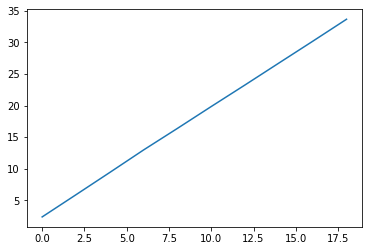

In [16]:
conds = []
x = []
for i in range(0, 10):
    conds.append(experiment(cheby_first_kind, cheby_first_kind, i*2, 1))
    x.append(i * 2)
plt.plot(x, conds)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

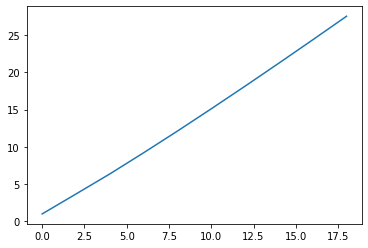

In [17]:
conds = []
x = []
for i in range(0, 10):
    conds.append(experiment(mono_poly, mono_poly, i*2, 1))
    x.append(i * 2)
plt.plot(x, conds)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

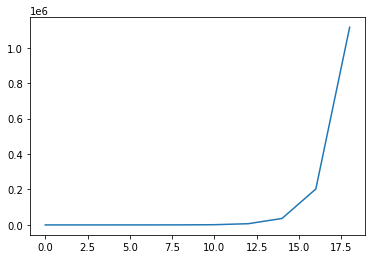

In [18]:
conds = []
x = []
for i in range(0, 10):
    conds.append(experiment(cheby_first_kind, mono_poly, i*2, 1))
    x.append(i * 2)
plt.plot(x, conds)
plt.show

In [19]:
experiment(cheby_first_kind, mono_poly, 8, 1)

243.95198338531648

In [25]:
x = syms('x')
y = syms('y')


In [27]:
cheby_first_kind(1, 4)

ValueError: Only support 2 variable max

In [26]:
T_2_1 = 1/8 * x**2 * y - 1/2 * y ** 2 - 1/2 * x

In [ ]:
T_2_2 = 